# Coursera Project Capstone- The Battle of Neighborhoods

### Introduction

Canada is a one of the most popular destination of Indian Engineering Students for advance studies and also for doing Internships like Mitacs etc. When new students go there, they usually miss the Indian foods badly, because of unique taste of native foods.
<p>
This Project is aimed to help them in finding <strong>the best Indian restaurants in Toronto, the provincial capital of Ontario, Canada</strong>. </p>

I chose Toronto, because, the highest concentrations of Indo-Canadians are found in the provinces of Ontario and British Columbia, followed by growing communities in Alberta and Quebec as well, with the majority of them being foreign-born.

### About Data


For the Toronto neighborhood data, a Wikipedia page: <a href = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'>wiki_page</a> exists that has all the information we need to explore and cluster the neighborhoods in Toronto. I will have to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format.




### Approach

I will collect the Toronto city data from above <a href = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'>link</a> and using <strong>FourSquare API</strong>, I will find all venues for each neighborhood. Then, filtering out all the venues that have Indian restaurants. I will analyse ratings, tips and count for Indian restaurants. I will sort that data and visualize the ranking of neighborhoods using <strong>folium library</strong> of Python.   


### Problem Statement :

<strong>Which is/are the best place/s to stay in the Toronto city if I prefer Indian foods ?</strong>



Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [70]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
#!pip install geocoder #uncomment if the module isn't installed
import os
#!pip install folium #uncomment if the module isn't installed
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


### Download, scrape and wrangle the data

In [73]:
# download data and parse it:
r = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = BeautifulSoup(r.text, 'html.parser')
table=soup.find('table', attrs={'class':'wikitable sortable'})

#get headers:
headers=table.findAll('th')
for i, head in enumerate(headers): headers[i]=str(headers[i]).replace("<th>","").replace("</th>","").replace("\n","")

#Find all items and skip first one:
rows=table.findAll('tr')
rows=rows[1:len(rows)]

# skip all meta symbols and line feeds between rows:
for i, row in enumerate(rows): rows[i] = str(rows[i]).replace("\n</td></tr>","").replace("<tr>\n<td>","")

# make dataframe, expand rows and drop the old one:
df=pd.DataFrame(rows)
df[headers] = df[0].str.split("</td>\n<td>", n = 2, expand = True) 
df.drop(columns=[0],inplace=True)

# skip not assigned boroughs:
df = df.drop(df[(df.Borough == "Not assigned")].index)
# give "Not assigned" Neighborhoods same name as Borough:
df.Neighborhood.replace("Not assigned", df.Borough, inplace=True)

# copy Borough value to Neighborhood if NaN:
df.Neighborhood.fillna(df.Borough, inplace=True)
# drop duplicate rows:
df=df.drop_duplicates()

# extract titles from columns
df.update(
    df.Neighborhood.loc[
        lambda x: x.str.contains('title')
    ].str.extract('title=\"([^\"]*)',expand=False))

df.update(
    df.Borough.loc[
        lambda x: x.str.contains('title')
    ].str.extract('title=\"([^\"]*)',expand=False))

# delete Toronto annotation from Neighbourhood:
df.update(
    df.Neighborhood.loc[
        lambda x: x.str.contains('Toronto')
    ].str.replace(", Toronto",""))
df.update(
    df.Neighborhood.loc[
        lambda x: x.str.contains('Toronto')
    ].str.replace("\(Toronto\)",""))

# combine multiple neighborhoods with the same post code
df2 = pd.DataFrame({'Postcode':df.Postcode.unique()})
df2['Borough']=pd.DataFrame(list(set(df['Borough'].loc[df['Postcode'] == x['Postcode']])) for i, x in df2.iterrows())
df2['Neighborhood']=pd.Series(list(set(df['Neighborhood'].loc[df['Postcode'] == x['Postcode']])) for i, x in df2.iterrows())
df2['Neighborhood']=df2['Neighborhood'].apply(lambda x: ', '.join(x))
df2.dtypes

df2.head()

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,Queen's Park


<strong>I will add Longitude and Latitude values for each neighborhood using <a href = 'http://cocl.us/Geospatial_data'>this data</a>.</strong>

In [74]:
#add Geo-spatial data
dfll= pd.read_csv("http://cocl.us/Geospatial_data")
dfll.rename(columns={'Postal Code':'Postcode'}, inplace=True)
dfll.set_index("Postcode")
df2.set_index("Postcode")
toronto_data=pd.merge(df2, dfll)
toronto_data.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494


In [75]:
# The "Post code" column is not needed
toronto_data = toronto_data.iloc[:, 1:]
toronto_data

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,Regent Park,43.654260,-79.360636
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Downtown Toronto,Queen's Park,43.662301,-79.389494
5,Queen's Park (Toronto),Queen's Park,43.667856,-79.532242
6,"Scarborough, Toronto","Malvern, Rouge",43.806686,-79.194353
7,North York,Don Mills North,43.745906,-79.352188
8,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
9,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


 ### Lets Visualize the location data :

In [76]:
# How many  neighborhood are there in Toronto City?
print("Total number of Neighborhood is {}".format(toronto_data.shape[0]))

Total number of Neighborhood is 103


<strong>Lets see which Borough has the most number of Neighborhood?</strong>

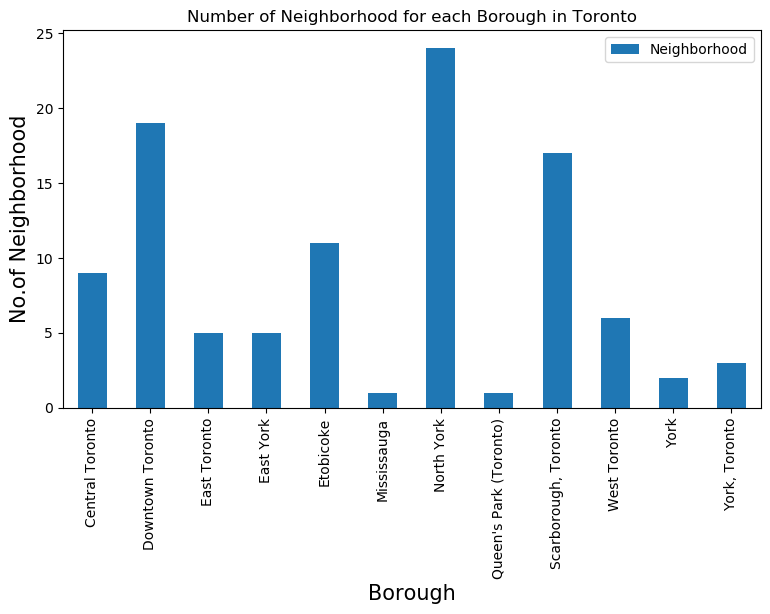

In [77]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
toronto_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [78]:
print("Maximum number of Neighborhoods in a single borough is {}".format(max(toronto_data.groupby('Borough')['Neighborhood'].count())))

Maximum number of Neighborhoods in a single borough is 24


### Define Foursquare Credentials and Version
All the below credentials are taken from <a href = 'https://foursquare.com/'>fourSquare</a>

In [150]:
CLIENT_ID = 'EU203ECLXW5SW1V211ZES5RUDZNHLCQ3HKADMVJHBUFZ4YLY' # your Foursquare ID
CLIENT_SECRET = 'IYS0KQOFTEKGJCJZHMKN32GMR1BNBTMS0F0RDDEMDHJNAWGA' # your Foursquare Secret
VERSION = '20200101'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EU203ECLXW5SW1V211ZES5RUDZNHLCQ3HKADMVJHBUFZ4YLY
CLIENT_SECRET:IYS0KQOFTEKGJCJZHMKN32GMR1BNBTMS0F0RDDEMDHJNAWGA


<strong> Define all the functions intract with FourSquare API and get top 50 venues within a radius of 2000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.</strong>

In [151]:
def get_venues(lat,lng):
    
    #set variables
    radius=2000
    LIMIT=50
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

<strong>Function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.</strong>

In [152]:
def get_venue_details(venue_id):
        
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Let's collect the Indian Restaurants for each of the Neighbourhood 

In [153]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
indirest_toronto = pd.DataFrame(columns=column_names)
count=1
for row in toronto_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants = venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(toronto_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category = resturant_detail
        indirest_toronto = indirest_toronto.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 103 ) Indian Resturants in Parkwoods, North York:0
( 2 / 103 ) Indian Resturants in Victoria Village, North York:1
( 3 / 103 ) Indian Resturants in Regent Park, Downtown Toronto:0
( 4 / 103 ) Indian Resturants in Lawrence Manor, Lawrence Heights, North York:0
( 5 / 103 ) Indian Resturants in Queen's Park , Downtown Toronto:0
( 6 / 103 ) Indian Resturants in Queen's Park , Queen's Park (Toronto):0
( 7 / 103 ) Indian Resturants in Malvern, Rouge, Scarborough, Toronto:0
( 8 / 103 ) Indian Resturants in Don Mills North, North York:0
( 9 / 103 ) Indian Resturants in Woodbine Gardens, Parkview Hill, East York:1
( 10 / 103 ) Indian Resturants in Garden District, Ryerson, Downtown Toronto:0
( 11 / 103 ) Indian Resturants in Glencairn, North York:0
( 12 / 103 ) Indian Resturants in Martin Grove, West Deane Park, Islington, Princess Gardens, Cloverdale, Etobicoke:0
( 13 / 103 ) Indian Resturants in Port Union, Highland Creek , Rouge Hill, Scarborough, Toronto:0
( 14 / 103 ) Indian Resturan

In [154]:
# lets see total number of indian restaurants in Toronto
print("Total number of Indian Restaurant in Toronto City is {}".format(indirest_toronto.shape[0]))

Total number of Indian Restaurant in Toronto City is 56


In [155]:
# lets print first five elements of Indian Restaurants
indirest_toronto.head()

,Borough,Neighborhood,ID,Name
0,North York,Victoria Village,4b9bccbef964a520ae2636e3,Sultan Of Samosas
1,East York,"Woodbine Gardens, Parkview Hill",4b9bccbef964a520ae2636e3,Sultan Of Samosas
2,York,Humewood-Cedarvale,52418b0b7e48222eea81d2d2,Pukka Restaurant
3,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro
4,"Scarborough, Toronto",Woburn,4bd48a734e32d13a4254bf80,Govardhan Thal


### Visualize the Indian Restaurants Data 

<strong> <em>Which Borough has the maximum number of Indian Rasoi ? </em></strong>

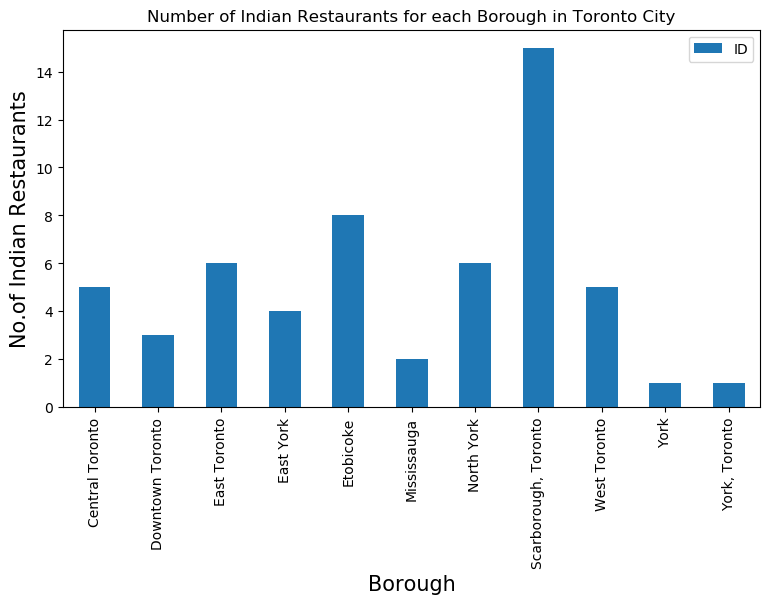

In [156]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants for each Borough in Toronto City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#giving a bar plot
indirest_toronto.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [157]:
print("Maximum number of Indian restaurants in a single Borough is {}".format(max(indirest_toronto.groupby('Borough')['ID'].count())))

Maximum number of Indian restaurants in a single Borough is 15


<strong> <em>Which Neighborhood has the maximum number of Indian Rasoi ? </em></strong>

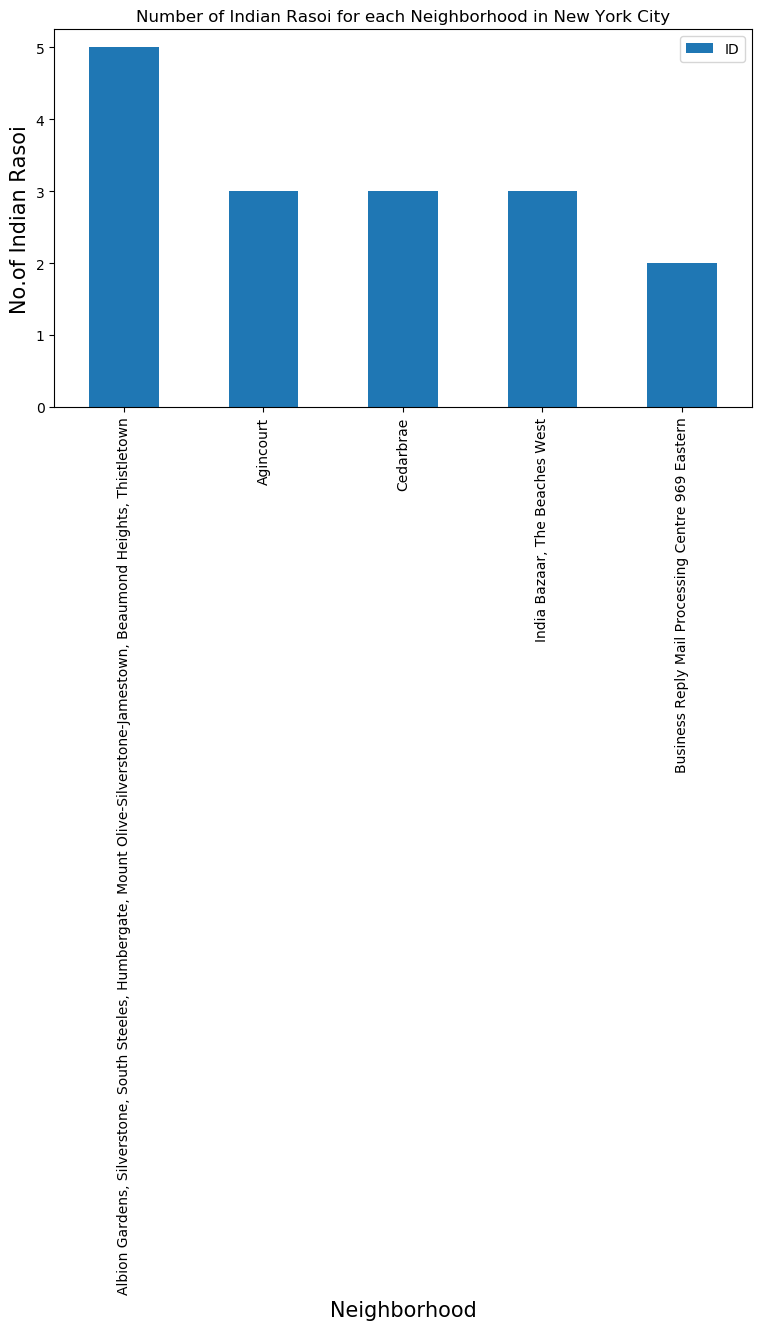

In [158]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Rasoi for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Rasoi', fontsize=15)
#giving a bar plot
indirest_toronto.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [159]:
print("Maximum number of Indian restaurants in a single Neighborhood is {}".format(max(indirest_toronto.groupby('Neighborhood')['ID'].count())))

Maximum number of Indian restaurants in a single Neighborhood is 5


### Let's see likes, ratings and tips

In [160]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats = pd.DataFrame(columns = column_names)
count=1


for row in indirest_toronto.values.tolist():
    Borough, Neighborhood, ID, Name = row
    try:
        venue_details = get_venue_details(ID)
        print(venue_details)
        id1, name, likes, rating, tips = venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id1, name, likes, rating, tips = [0]*5
    print('(',count,'/',len(indirest_toronto),')','processed')
    indian_rest_stats = indian_rest_stats.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id1,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID               Name  Likes  Rating  Tips
0  4b9bccbef964a520ae2636e3  Sultan Of Samosas     29     8.4    24
( 1 / 56 ) processed
                         ID               Name  Likes  Rating  Tips
0  4b9bccbef964a520ae2636e3  Sultan Of Samosas     29     8.4    24
( 2 / 56 ) processed
                         ID              Name  Likes  Rating  Tips
0  52418b0b7e48222eea81d2d2  Pukka Restaurant     41     9.0    26
( 3 / 56 ) processed
                         ID          Name  Likes  Rating  Tips
0  4dcd7c6352b1f8915b7e7f7e  Delhi Bistro      6     7.1     3
( 4 / 56 ) processed
                         ID            Name  Likes  Rating  Tips
0  4bd48a734e32d13a4254bf80  Govardhan Thal      7     7.2     3
( 5 / 56 ) processed
                         ID           Name  Likes  Rating  Tips
0  4c77fc87bd346dcb8c90f0ef  La Sani Grill     12     6.6    12
( 6 / 56 ) processed
                         ID                        Name  Likes  Rating  Tips
0  4daf

In [161]:
# print first five elements of indian_rest_stats
print(indian_rest_stats.columns)

Index(['Borough', 'Neighborhood', 'ID', 'Name', 'Likes', 'Rating', 'Tips'], dtype='object')


In [172]:
# print the shape of indian_rest_stats
print(indian_rest_stats)

                 Borough                                       Neighborhood  \
0             North York                                   Victoria Village   
1              East York                    Woodbine Gardens, Parkview Hill   
2                   York                                 Humewood-Cedarvale   
3           East Toronto                                        The Beaches   
4   Scarborough, Toronto                                             Woburn   
5   Scarborough, Toronto                                             Woburn   
6              East York                                            Leaside   
7              East York                                            Leaside   
8       Downtown Toronto                                           Christie   
9       Downtown Toronto                                           Christie   
10  Scarborough, Toronto                                          Cedarbrae   
11  Scarborough, Toronto                            

### Let's seet the Neighbourhood with maximum average rating of Indian Restaurant

In [173]:

toronto_neighborhood_stats = indian_rest_stats.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
toronto_neighborhood_stats.columns = ['Neighborhood','Average Rating']
toronto_neighborhood_stats.sort_values(by = 'Average Rating', ascending = False, inplace = True)

toronto_neighborhood_stats.head()

,Neighborhood,Average Rating
16,Humewood-Cedarvale,9.00
12,"Dufferin, Dovercourt Village",8.95
7,Christie,8.85
20,"Rathnelly, Deer Park, South Hill, Summerhill W...",8.80
35,"Yorkville, The Annex, North Midtown",8.80


In [174]:
# print the neighborhood with maximum rating
print("Neighborhood : {}, Average Rating : {}".format(toronto_neighborhood_stats.iloc[0][0] ,toronto_neighborhood_stats.iloc[0][1]))

Neighborhood : Humewood-Cedarvale, Average Rating : 9.0


<strong>Lets merge this data with original data</strong>

In [175]:
toronto_neighborhood_stats = pd.merge(toronto_neighborhood_stats,toronto_data, on='Neighborhood')
toronto_neighborhood_stats.reset_index()
toronto_neighborhood_stats

,Neighborhood,Average Rating,Borough,Latitude,Longitude
0,Humewood-Cedarvale,9.000000,York,43.693781,-79.428191
1,"Dufferin, Dovercourt Village",8.950000,West Toronto,43.669005,-79.442259
2,Christie,8.850000,Downtown Toronto,43.669542,-79.422564
3,"Rathnelly, Deer Park, South Hill, Summerhill W...",8.800000,Central Toronto,43.686412,-79.400049
4,"Yorkville, The Annex, North Midtown",8.800000,Central Toronto,43.672710,-79.405678
5,Victoria Village,8.400000,North York,43.725882,-79.315572
6,"Woodbine Gardens, Parkview Hill",8.400000,East York,43.706397,-79.309937
7,"Clairlea, Oakridge, Golden Mile",8.400000,"Scarborough, Toronto",43.711112,-79.284577
8,"Cabbagetown, St. James Town",8.300000,Downtown Toronto,43.667967,-79.367675
9,Scarborough Village,8.300000,"Scarborough, Toronto",43.744734,-79.239476


### Let's use folium for visualization using map


In [177]:
toronto_map = folium.Map(location = [43.653963, -79.387207 ], zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in toronto_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
    
toronto_map

<strong>Create labels also</strong>

In [179]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location = [43.653963, -79.387207 ], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_neighborhood_stats['Latitude'], toronto_neighborhood_stats['Longitude'], toronto_neighborhood_stats['Borough'], toronto_neighborhood_stats['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

##### Save the map

In [181]:
map_toronto.save('Neighbourhood_rating.html')


## Conclusion

<ul>
    <li>Humewood-Cedarvale,Dufferin, Dovercourt Village	are some of the best neighborhoods for Indian Restaurants. </li>
    <li>York (borough) is the best place if you prefer Indian foods.</li>
</ul>

## Limitations

<ul><li>The accuracy is dependent on the data provided by FourSquare and the ranking is dependent on the user ratings.</li></ul>